## **Importations :**
<div style="border-bottom: 4px solid blue; margin-bottom: 20px;"></div>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Creation des dataloaders**
<div style="border-bottom: 4px solid blue; margin-bottom: 20px;"></div>

#### 1. charger les données

In [3]:
def load_data(input_file, output_file):
    input_sequences = pd.read_csv(input_file)
    output_sequences = pd.read_csv(output_file)
    return input_sequences, output_sequences


#### 2. Division les données

In [4]:
### Préparer les données pour Transformers
def prepare_transformer_data(input_sequences, output_sequences, test_size=0.2, val_size=0.1, random_state=42):
    video_object_ids = input_sequences.iloc[:, :2].values  # `video_id`, `object_id`

    # Extraire les séquences d'entrée et de sortie
    X = input_sequences.iloc[:, 2:].values  # Frames pour l'encodage
    y = output_sequences.iloc[:, 2:].values  # Frames pour le décodage

    # Diviser les données en ensembles d'entraînement, validation et test
    X_train_val, X_test, y_train_val, y_test, ids_train_val, ids_test = train_test_split(
        X, y, video_object_ids, test_size=test_size, random_state=random_state
    )
    X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
        X_train_val, y_train_val, ids_train_val, test_size=val_size, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, ids_train, ids_val, ids_test


#### 3. Creation d'un dataset personnalisé
    ✅ Organisation structurée 
    ✅ Compatibilité avec PyTorch 

In [5]:
class VideoDataset(Dataset):
    def __init__(self, X, y, ids):
        self.X = torch.tensor(X, dtype=torch.float32)  # Séquences d'entrée
        self.y = torch.tensor(y, dtype=torch.float32)  # Séquences de sortie
        self.ids = torch.tensor(ids, dtype=torch.long)  # Identifiants (video_id, object_id)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            'input': self.X[idx],
            'target': self.y[idx],
            'meta': self.ids[idx]  # Utilisation de 'meta' pour les identifiants
        }

#### 4. conversion en tensor

In [6]:
def convert_to_tensors(X_train, X_val, X_test, y_train, y_val, y_test, device='cpu'):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
    
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)
    
    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor


#### 5. Creation du DataLoader

In [7]:
def create_dataloaders(X_train, y_train, ids_train, X_val, y_val, ids_val, X_test, y_test, ids_test, batch_size=32):
    # Creer des datasets PyTorch
    train_dataset = VideoDataset(X_train, y_train, ids_train)
    val_dataset = VideoDataset(X_val, y_val, ids_val)
    test_dataset = VideoDataset(X_test, y_test, ids_test)
    # Creer les dataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [8]:
# Chargement des données
input_file = '../data/annotations_transformers/input_sequences.csv'
output_file = '../data/annotations_transformers/output_sequences.csv'


In [9]:
# appliquer la fonction load_data
input_sequences, output_sequences = load_data(input_file, output_file)


In [10]:
# utiliser la fonction prepare_transformer_data pour diviser les données 
X_train, X_val, X_test, y_train, y_val, y_test, ids_train, ids_val, ids_test = prepare_transformer_data(
    input_sequences, output_sequences
)

In [11]:
# convertir en tensor
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = convert_to_tensors(
    X_train, X_val, X_test, y_train, y_val, y_test, device
)

In [12]:
# creer les dataloaders
batch_size = 32
train_loader, val_loader, test_loader = create_dataloaders(
    X_train_tensor, y_train_tensor, ids_train,
    X_val_tensor, y_val_tensor, ids_val,
    X_test_tensor, y_test_tensor, ids_test,
    batch_size=batch_size
)

C:\Users\h\AppData\Local\Temp\ipykernel_13808\714682715.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Séquences d'entrée
C:\Users\h\AppData\Local\Temp\ipykernel_13808\714682715.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)  # Séquences de sortie


## Encodage positionnel
<div style="border-bottom: 4px solid blue; margin-bottom: 20px;"></div>


In [13]:
def add_positional_encoding(data, sequence_length, d_model):
    #crée un vecteur représentant chaque position dans la séquence.
    position = torch.arange(sequence_length).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
    #Creer de la matrice d’encodage positionnel
    pos_encoding = torch.zeros(sequence_length, d_model)
    pos_encoding[:, 0::2] = torch.sin(position * div_term)
    pos_encoding[:, 1::2] = torch.cos(position * div_term)
    return data + pos_encoding

## La classe *TransformerModel* combine LSTM et Transformer 
<div style="border-bottom: 4px solid blue; margin-bottom: 20px;"></div>

In [14]:
# Modèle Transformer amélioré
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.5):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        
        # Embeddings pour les entrées et les sorties
        self.embedding = nn.Linear(input_dim, d_model)
        self.output_embedding = nn.Linear(output_dim, d_model)
        
        # Encodeur LSTM pour capturer les dépendances temporelles
        self.lstm_encoder = nn.LSTM(d_model, d_model, batch_first=True)
        
        # Encodeur Transformer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, 
                nhead=nhead, 
                dim_feedforward=dim_feedforward, 
                dropout=dropout
            ), 
            num_layers=num_encoder_layers
        )
        
        # Décodeur Transformer avec attention multi-têtes
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=d_model, 
                nhead=nhead, 
                dim_feedforward=dim_feedforward, 
                dropout=dropout
            ), 
            num_layers=num_decoder_layers
        )
        
        # Tête de sortie
        self.fc_out = nn.Linear(d_model, output_dim)
        
    def forward(self, src, tgt):
        # Embedding des entrées et des sorties
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.output_embedding(tgt) * math.sqrt(self.d_model)
        
        # Ajouter l'encodage positionnel
        src = add_positional_encoding(src, src.size(0), self.d_model)
        tgt = add_positional_encoding(tgt, tgt.size(0), self.d_model)
        
        # Passage à travers l'encodeur LSTM
        lstm_out, _ = self.lstm_encoder(src)
        
        # Passage à travers l'encodeur Transformer
        memory = self.transformer_encoder(lstm_out)
        
        # Passage à travers le décodeur Transformer
        output = self.transformer_decoder(tgt, memory)
        
        # Sortie du modèle
        output = self.fc_out(output)
        
        return output

#### Initialisation du modèle

In [15]:
input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor.shape[1]
model = TransformerModel(input_dim, output_dim)


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### la fonction de perte et l'optimiseur

In [16]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

### Calcul de ADE et FDE 

In [17]:
def compute_ade_fde(predictions, targets):
    #Calcul ADE (Average Displacement Error)
    ade = torch.mean(torch.sqrt(torch.sum((predictions - targets) ** 2, dim=-1)))
    #Calcul FDE (Final Displacement Error)
    fde = torch.sqrt(torch.sum((predictions[:, -1] - targets[:, -1]) ** 2, dim=-1)).mean()
    return ade.item(), fde.item()

In [18]:
import matplotlib.pyplot as plt
def plot_training_metrics(train_ade_list, train_fde_list, val_ade_list, val_fde_list):
    epochs = range(1, len(train_ade_list) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Tracer ADE
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_ade_list, label='Train ADE', marker='o', linestyle='-')
    plt.plot(epochs, val_ade_list, label='Validation ADE', marker='s', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('ADE')
    plt.title('Évolution de lADE')
    plt.legend()
    plt.grid(True)
    
    # Tracer FDE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_fde_list, label='Train FDE', marker='o', linestyle='-')
    plt.plot(epochs, val_fde_list, label='Validation FDE', marker='s', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('FDE')
    plt.title('Évolution du FDE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Fonction de validation

In [19]:
def validate(model, val_loader):
    model.eval()
    val_loss = 0.0
    ade, fde = 0.0, 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(inputs, targets)
            
            loss = criterion(outputs.view(-1, output_dim), targets.view(-1, output_dim))
            val_loss += loss.item()
            
            batch_ade, batch_fde = compute_ade_fde(outputs, targets)
            ade += batch_ade
            fde += batch_fde

    val_loss /= len(val_loader)
    ade /= len(val_loader)
    fde /= len(val_loader)
    
    return val_loss, ade, fde

## Entraînement du Modele
<div style="border-bottom: 4px solid blue; margin-bottom: 20px;"></div>

In [20]:
def train_model(model, train_loader, val_loader, epochs=10):
    train_ade_list, train_fde_list = [], []
    val_ade_list, val_fde_list = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        ade, fde = 0.0, 0.0

        for batch in train_loader:
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs, targets)
            
            loss = criterion(outputs.view(-1, output_dim), targets.view(-1, output_dim))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batch_ade, batch_fde = compute_ade_fde(outputs, targets)
            ade += batch_ade
            fde += batch_fde
        
        running_loss /= len(train_loader)
        ade /= len(train_loader)
        fde /= len(train_loader)
        
        val_loss, val_ade, val_fde = validate(model, val_loader)
        
        print("=" * 50)
        print(f"🕒 Epoch {epoch+1}/{epochs}")
        print("-" * 50)
        print(f"📉 Train Loss     : {running_loss:.4f}")
        print(f"📍 Train ADE      : {ade:.4f}")
        print(f"🎯 Train FDE      : {fde:.4f}")

        
        train_ade_list.append(ade)
        train_fde_list.append(fde)
        val_ade_list.append(val_ade)
        val_fde_list.append(val_fde)
    
    plot_training_metrics(train_ade_list, train_fde_list, val_ade_list, val_fde_list)


🕒 Epoch 1/10
--------------------------------------------------
📉 Train Loss     : 0.0467
📍 Train ADE      : 0.7518
🎯 Train FDE      : 0.3561
🕒 Epoch 2/10
--------------------------------------------------
📉 Train Loss     : 0.0337
📍 Train ADE      : 0.6434
🎯 Train FDE      : 0.0938
🕒 Epoch 3/10
--------------------------------------------------
📉 Train Loss     : 0.0056
📍 Train ADE      : 0.2427
🎯 Train FDE      : 0.0709
🕒 Epoch 4/10
--------------------------------------------------
📉 Train Loss     : 0.0009
📍 Train ADE      : 0.0900
🎯 Train FDE      : 0.0203
🕒 Epoch 5/10
--------------------------------------------------
📉 Train Loss     : 0.0003
📍 Train ADE      : 0.0542
🎯 Train FDE      : 0.0114
🕒 Epoch 6/10
--------------------------------------------------
📉 Train Loss     : 0.0002
📍 Train ADE      : 0.0406
🎯 Train FDE      : 0.0078
🕒 Epoch 7/10
--------------------------------------------------
📉 Train Loss     : 0.0001
📍 Train ADE      : 0.0323
🎯 Train FDE      : 0.0052
🕒 Epoc

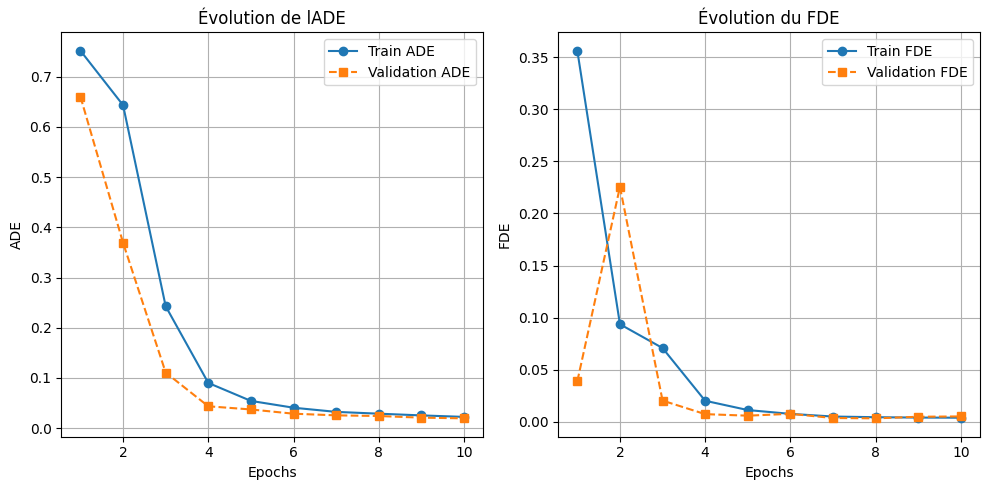

In [21]:
train_model(model, train_loader, val_loader, epochs=10)

In [ ]:
import matplotlib.pyplot as plt

# Fonction pour afficher les prédictions et les cibles
def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            # Prédictions du modèle
            predictions = model(inputs, targets)
            
            # Sélectionner un sous-ensemble des données pour la visualisation
            for i in range(num_samples):
                plt.figure(figsize=(12, 6))

                # Visualisation de la prédiction vs. la cible
                plt.subplot(1, 2, 1)
                plt.plot(targets[i].cpu().numpy(), label="Cible", color='blue')
                plt.plot(predictions[i].cpu().numpy(), label="Prédiction", color='red')
                plt.title(f"Prédiction vs Cible (Échantillon {i+1})")
                plt.xlabel("Index de la Frame")
                plt.ylabel("Position")
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(targets[i].cpu().numpy(), label="Cible", color='blue')
                plt.title(f"Cible (Échantillon {i+1})")
                plt.xlabel("Index de la Frame")
                plt.ylabel("Position")

                plt.tight_layout()
                plt.show()
            
            break  # Ne visualiser qu'un lot

# Appel de la fonction pour afficher les prédictions et cibles
visualize_predictions(model, test_loader, num_samples=5)


In [22]:
# Sauvegarder le modèle
import torch
torch.save(model.state_dict(), 'model.pth')


In [23]:

torch.save({ 
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  
}, 'model_checkpoint.pth')
